In [1]:
cd ..

/home/abhishekabhishek/git/AQT-KimGroup


In [57]:
from keys import keys
from qiskit import IBMQ, assemble, QuantumCircuit, quantum_info
from qiskit.visualization import plot_histogram

%matplotlib inline

In [3]:
import numpy as np

In [4]:
# Setup account
provider = IBMQ.enable_account(keys['ibmq_token'])

In [5]:
#IBMQ.save_account(keys['ibmq_token'])

In [6]:
devices = provider.backends(simulator=True, operational=True)
for x in devices:
    print(x.name(), x.configuration().n_qubits, x.status().pending_jobs)

ibmq_qasm_simulator 32 0
simulator_statevector 32 0
simulator_mps 100 0
simulator_extended_stabilizer 63 0
simulator_stabilizer 5000 0


In [51]:
simulator_backend = provider.backend.ibmq_qasm_simulator
sim = provider.backend.ibmq_qasm_simulator

Test the ordering or endian-ness of the Qiskit results

In [61]:
# No. of qubits
n_qubits = 2

# Initialize the quantum register and circuit
circ = QuantumCircuit(n_qubits, n_qubits)

# Add operations to the circuit to prepage a GHZ state
circ.h(0)
circ.measure([0, 1], [0, 1])
circ.draw()

┌───┐┌─┐
q_0: ┤ H ├┤M├
     └┬─┬┘└╥┘
q_1: ─┤M├──╫─
      └╥┘  ║ 
c_0: ══╬═══╩═
       ║     
c_1: ══╩═════

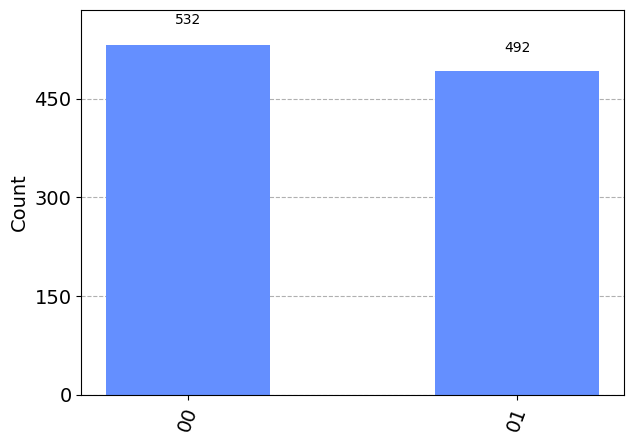

In [62]:
# Simple qiskit running
qobj = assemble(circ)  # Assemble circuit into a Qobj that can be run
counts = sim.run(qobj).result().get_counts()  # Do the simulation, returning the state vector
plot_histogram(counts)

In [27]:
res = simulator_backend.run(circ)

In [32]:
res.job_id()

'63914de0bf5d5bc5447a9459'

In [33]:
job = simulator_backend.retrieve_job('63914de0bf5d5bc5447a9459')
result = job.result()

In [37]:
print(type(res), type(result))

<class 'qiskit.providers.ibmq.job.ibmqjob.IBMQJob'> <class 'qiskit.result.result.Result'>


In [41]:
result.data

<bound method Result.data of Result(backend_name='ibmq_qasm_simulator', backend_version='0.11.0', qobj_id='05d298d9-4067-4cbe-8fcd-89ba94d7f5bf', job_id='63914de0bf5d5bc5447a9459', success=True, results=[ExperimentResult(shots=4000, success=True, meas_level=2, data=ExperimentResultData(), header=QobjExperimentHeader(clbit_labels=[], creg_sizes=[], global_phase=0.0, memory_slots=0, metadata={}, n_qubits=2, name='circuit-469', qreg_sizes=[['q1', 2]], qubit_labels=[['q1', 0], ['q1', 1]]), status=DONE, metadata={'active_input_qubits': [], 'batched_shots_optimization': False, 'device': 'CPU', 'input_qubit_map': [], 'measure_sampling': False, 'method': 'stabilizer', 'num_clbits': 0, 'num_qubits': 0, 'parallel_shots': 1, 'parallel_state_update': 16, 'remapped_qubits': False}, seed_simulator=3575260803, time_taken=1.3958e-05)], date=2022-12-07 18:37:23.765184-08:00, status=COMPLETED, header=QobjHeader(backend_name='ibmq_qasm_simulator', backend_version='0.1.547'), metadata={'max_gpu_memory_mb'

Reproducing Qiskit MLE


The following was part of the old notebook but is now deprecated in qiskit - 
`from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter`

In [8]:
from qiskit_experiments.library import StateTomography, tomography

In [64]:
# No. of qubits
n_qubits = 3

# Initialize the quantum register and circuit
ghz_circ = QuantumCircuit(n_qubits)

# Add operations to the circuit to prepage a GHZ state
ghz_circ.h(0)
for idx in range(n_qubits-1):
    ghz_circ.cx(idx, idx+1)

ghz_circ.draw()

┌───┐          
q_0: ┤ H ├──■───────
     └───┘┌─┴─┐     
q_1: ─────┤ X ├──■──
          └───┘┌─┴─┐
q_2: ──────────┤ X ├
               └───┘

In [65]:
qst_exp = StateTomography(ghz_circ)
qst_data_1 = qst_exp.run(simulator_backend, seed_simulation=100).block_for_results()
for circuit in qst_exp.circuits():
    print(circuit.draw())

     ┌───┐           ░ ┌────────────┐ ░ ┌─┐      
q_0: ┤ H ├──■────────░─┤ PauliMeasZ ├─░─┤M├──────
     └───┘┌─┴─┐      ░ ├────────────┤ ░ └╥┘┌─┐   
q_1: ─────┤ X ├──■───░─┤ PauliMeasZ ├─░──╫─┤M├───
          └───┘┌─┴─┐ ░ ├────────────┤ ░  ║ └╥┘┌─┐
q_2: ──────────┤ X ├─░─┤ PauliMeasZ ├─░──╫──╫─┤M├
               └───┘ ░ └────────────┘ ░  ║  ║ └╥┘
c_0: ════════════════════════════════════╩══╬══╬═
                                            ║  ║ 
c_1: ═══════════════════════════════════════╩══╬═
                                               ║ 
c_2: ══════════════════════════════════════════╩═
                                                 
     ┌───┐           ░ ┌────────────┐ ░ ┌─┐      
q_0: ┤ H ├──■────────░─┤ PauliMeasZ ├─░─┤M├──────
     └───┘┌─┴─┐      ░ ├────────────┤ ░ └╥┘┌─┐   
q_1: ─────┤ X ├──■───░─┤ PauliMeasZ ├─░──╫─┤M├───
          └───┘┌─┴─┐ ░ ├────────────┤ ░  ║ └╥┘┌─┐
q_2: ──────────┤ X ├─░─┤ PauliMeasX ├─░──╫──╫─┤M├
               └───┘ ░ └────────────┘ ░  ║  ║ └╥┘


Following the introduction to the experiment framework at `https://qiskit.org/documentation/experiments/apidocs/framework.html#module-qiskit_experiments.framework`

In [68]:
job = simulator_backend.retrieve_job(qst_data_1.job_ids[0])
result = job.result()

In [ ]:
# Saved experiments
# 3 qubit GHZ - 6390ffde5252115aa3e127c1 

In [69]:
Nq = 3
Nset = 3**Nq
for i in range(Nset):
    print(result.results[i].header.name.split('_')[1][1:-1].split(', '), result.get_counts(i))

['0', '0', '0'] {'000': 2041, '111': 1959}
['0', '0', '1'] {'000': 1012, '011': 967, '100': 1003, '111': 1018}
['0', '0', '2'] {'000': 971, '011': 1011, '100': 975, '111': 1043}
['0', '1', '0'] {'000': 951, '010': 1005, '101': 1029, '111': 1015}
['0', '1', '1'] {'000': 524, '001': 501, '010': 485, '011': 468, '100': 545, '101': 501, '110': 494, '111': 482}
['0', '1', '2'] {'000': 483, '001': 487, '010': 543, '011': 496, '100': 492, '101': 496, '110': 486, '111': 517}
['0', '2', '0'] {'000': 960, '010': 1044, '101': 1017, '111': 979}
['0', '2', '1'] {'000': 489, '001': 525, '010': 497, '011': 486, '100': 513, '101': 474, '110': 521, '111': 495}
['0', '2', '2'] {'000': 489, '001': 523, '010': 513, '011': 512, '100': 455, '101': 515, '110': 476, '111': 517}
['1', '0', '0'] {'000': 983, '001': 1003, '110': 989, '111': 1025}
['1', '0', '1'] {'000': 505, '001': 494, '010': 494, '011': 546, '100': 494, '101': 484, '110': 496, '111': 487}
['1', '0', '2'] {'000': 509, '001': 493, '010': 487, '0

By comparing the above expt. header names, with the circuits, it is clear to see the mapping Z -> 0, X -> 1, Y -> 2. This is similar to what was previously being used in the deprecated library.

In [73]:
Nq = 3
Nset = 3**Nq

collateddata = np.zeros((2700, 3), dtype=int)
di = 0
for nset in range(Nset):
    # Raw measurement counts e.g. {'000':X, '111':Y}
    rawdata = result.get_counts(nset)
    # Measurement setup e.g. ['0', '0', '0'] -> [Z, Z, Z]
    setting = result.results[nset].header.name.split('_')[1][1:-1].split(', ')
    setstr = ''
    for nq in range(Nq):
        setstr += setting[nq]
    
    for st in rawdata:
        # Map the projective outcomes to POVM outcomes
        # e.g. given setting [100], map outcome [000] to [200] and [111] to
        # [311]
        outcome = np.array([3*int(st[2-i])+int(setstr[i]) for i in range(3)])
        collateddata[di:di+rawdata[st]] = outcome
        di += rawdata[st]

print(di, len(collateddata))
assert(di==2700)

108000 2700


AssertionError: 

In [27]:
result.data

<bound method Result.data of Result(backend_name='ibmq_qasm_simulator', backend_version='0.11.0', qobj_id='536c4a81-19a1-45fd-83ac-db8b1050e244', job_id='639020b8d26abd241a25a58b', success=True, results=[ExperimentResult(shots=4000, success=True, meas_level=2, data=ExperimentResultData(counts={'0x0': 1966, '0x7': 2034}), header=QobjExperimentHeader(clbit_labels=[['c', 0], ['c', 1], ['c', 2]], creg_sizes=[['c', 3]], global_phase=0.0, memory_slots=3, metadata={'clbits': [0, 1, 2], 'm_idx': [0, 0, 0]}, n_qubits=3, name='StateTomography_(0, 0, 0)', qreg_sizes=[['q', 3]], qubit_labels=[['q', 0], ['q', 1], ['q', 2]]), status=DONE, metadata={'active_input_qubits': [0, 1, 2], 'batched_shots_optimization': False, 'device': 'CPU', 'fusion': {'enabled': False}, 'input_qubit_map': [[2, 2], [1, 1], [0, 0]], 'measure_sampling': True, 'method': 'stabilizer', 'noise': 'ideal', 'num_clbits': 3, 'num_qubits': 3, 'parallel_shots': 1, 'parallel_state_update': 16, 'remapped_qubits': False, 'sample_measure_

In [44]:
st_analysis = tomography.StateTomographyAnalysis()
qst_exp_res = st_analysis.run(qst_exp_data)

In [45]:
qst_exp_res.data()

[{'counts': {'000': 2005, '111': 1995},
  'job_id': '636c55240565be2b3600742c',
  'metadata': {'clbits': [0, 1, 2], 'm_idx': [0, 0, 0]},
  'shots': 4000,
  'meas_level': <MeasLevel.CLASSIFIED: 2>},
 {'counts': {'000': 1013, '011': 942, '100': 1042, '111': 1003},
  'job_id': '636c55240565be2b3600742c',
  'metadata': {'clbits': [0, 1, 2], 'm_idx': [0, 0, 1]},
  'shots': 4000,
  'meas_level': <MeasLevel.CLASSIFIED: 2>},
 {'counts': {'000': 1019, '011': 1005, '100': 980, '111': 996},
  'job_id': '636c55240565be2b3600742c',
  'metadata': {'clbits': [0, 1, 2], 'm_idx': [0, 0, 2]},
  'shots': 4000,
  'meas_level': <MeasLevel.CLASSIFIED: 2>},
 {'counts': {'000': 951, '010': 990, '101': 1017, '111': 1042},
  'job_id': '636c55240565be2b3600742c',
  'metadata': {'clbits': [0, 1, 2], 'm_idx': [0, 1, 0]},
  'shots': 4000,
  'meas_level': <MeasLevel.CLASSIFIED: 2>},
 {'counts': {'000': 482,
   '001': 490,
   '010': 517,
   '011': 468,
   '100': 511,
   '101': 517,
   '110': 513,
   '111': 502},
  'j

In [46]:
qst_exp_data = qst_exp_res.data()
keys = [qst_exp_data[i].keys() for i in range(len(qst_exp_data))]
print(keys)

[dict_keys(['counts', 'job_id', 'metadata', 'shots', 'meas_level']), dict_keys(['counts', 'job_id', 'metadata', 'shots', 'meas_level']), dict_keys(['counts', 'job_id', 'metadata', 'shots', 'meas_level']), dict_keys(['counts', 'job_id', 'metadata', 'shots', 'meas_level']), dict_keys(['counts', 'job_id', 'metadata', 'shots', 'meas_level']), dict_keys(['counts', 'job_id', 'metadata', 'shots', 'meas_level']), dict_keys(['counts', 'job_id', 'metadata', 'shots', 'meas_level']), dict_keys(['counts', 'job_id', 'metadata', 'shots', 'meas_level']), dict_keys(['counts', 'job_id', 'metadata', 'shots', 'meas_level']), dict_keys(['counts', 'job_id', 'metadata', 'shots', 'meas_level']), dict_keys(['counts', 'job_id', 'metadata', 'shots', 'meas_level']), dict_keys(['counts', 'job_id', 'metadata', 'shots', 'meas_level']), dict_keys(['counts', 'job_id', 'metadata', 'shots', 'meas_level']), dict_keys(['counts', 'job_id', 'metadata', 'shots', 'meas_level']), dict_keys(['counts', 'job_id', 'metadata', 'sho

In [49]:
pauli_basis = tomography.basis.PauliMeasurementBasis

rho_li = tomography.fitters.linear_inversion(None, None, None,
                                             measurement_basis=pauli_basis)

TypeError: linear_inversion() missing 3 required positional arguments: 'shot_data', 'measurement_data', and 'preparation_data'

In [51]:
pauli_basis = tomography.basis.PauliMeasurementBasis()
